In [19]:
# Gerekli kütüphaneleri import ediyoruz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# spaCy'nin İngilizce dil modeli yükleniyor
nlp = spacy.load("en_core_web_sm")


In [20]:
# Kaggle'dan aldığımız Corona_NLP veri setini yüklüyoruz
train_df = pd.read_csv("Corona_NLP_train.csv", encoding='latin1')
test_df = pd.read_csv("Corona_NLP_test.csv", encoding='latin1')

# Veri setindeki kolon isimlerine bakıyoruz
print(train_df.columns)


Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')


In [ ]:
import re

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # HTML Etiketleri
    text = re.sub(r'http\S+|www\S+', '', text)  # URL'ler
    text = re.sub(r'\d+', '', text)  # Sayılar
    text = re.sub(r'[^\w\s]', '', text)  # Noktalama
    text = text.lower()  # Küçük harfe çevir
    return text

train_df['cleaned_text'] = train_df['OriginalTweet'].apply(clean_text)
test_df['cleaned_text'] = test_df['OriginalTweet'].apply(clean_text)

print(train_df[['OriginalTweet', 'cleaned_text']].head())


                                       OriginalTweet  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   
1  advice Talk to your neighbours family to excha...   
2  Coronavirus Australia: Woolworths to give elde...   
3  My food stock is not the only one which is emp...   
4  Me, ready to go at supermarket during the #COV...   

                                        cleaned_text  
0            menyrbie phil_gahan chrisitv  and  and   
1  advice talk to your neighbours family to excha...  
2  coronavirus australia woolworths to give elder...  
3  my food stock is not the only one which is emp...  
4  me ready to go at supermarket during the covid...  


In [22]:
def spacy_preprocess(text):
    doc = nlp(text)  
    tokens = []
    for token in doc:
        # Stopword olmayan ve boşluk olmayan token'ları topluyoruz
        if not token.is_stop and not token.is_punct and not token.is_space:
            tokens.append(token.lemma_)  # Lemmatization uyguluyoruz
    return " ".join(tokens)  

train_df['processed_text'] = train_df['cleaned_text'].apply(spacy_preprocess)
test_df['processed_text'] = test_df['cleaned_text'].apply(spacy_preprocess)

print(train_df[['OriginalTweet', 'processed_text']].head())


                                       OriginalTweet  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   
1  advice Talk to your neighbours family to excha...   
2  Coronavirus Australia: Woolworths to give elde...   
3  My food stock is not the only one which is emp...   
4  Me, ready to go at supermarket during the #COV...   

                                      processed_text  
0                       menyrbie phil_gahan chrisitv  
1  advice talk neighbour family exchange phone nu...  
2  coronavirus australia woolworth elderly disabl...  
3  food stock not panic food need stay calm stay ...  
4  ready supermarket covid outbreak m paranoid fo...  


In [23]:
# TF-IDF vektörizer'ı tanımlıyoruz
tfidf = TfidfVectorizer(max_features=5000)

# TF-IDF dönüşümünü uyguluyoruz
X_train = tfidf.fit_transform(train_df['processed_text'])
X_test = tfidf.transform(test_df['processed_text'])

# Hedef değişken (etiket) olarak Sentiment kolonunu kullanıyoruz
y_train = train_df['Sentiment']
y_test = test_df['Sentiment']


In [24]:
# Naive Bayes Modeli Eğitimi
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Test verisiyle tahmin yapma
y_pred_nb = nb_model.predict(X_test)

# Sonuçları raporlama
print("=== Naive Bayes Sınıflandırıcı ===")
print(classification_report(y_test, y_pred_nb))


=== Naive Bayes Sınıflandırıcı ===
                    precision    recall  f1-score   support

Extremely Negative       0.69      0.14      0.23       592
Extremely Positive       0.74      0.18      0.29       599
          Negative       0.42      0.54      0.47      1041
           Neutral       0.54      0.32      0.40       619
          Positive       0.36      0.70      0.48       947

          accuracy                           0.42      3798
         macro avg       0.55      0.38      0.38      3798
      weighted avg       0.52      0.42      0.40      3798



In [25]:
# Lojistik Regresyon Modeli Eğitimi
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Test verisiyle tahmin yapma
y_pred_lr = lr_model.predict(X_test)

# Sonuçları raporlama
print("=== Lojistik Regresyon Sınıflandırıcı ===")
print(classification_report(y_test, y_pred_lr))


=== Lojistik Regresyon Sınıflandırıcı ===
                    precision    recall  f1-score   support

Extremely Negative       0.65      0.47      0.55       592
Extremely Positive       0.65      0.53      0.58       599
          Negative       0.51      0.52      0.52      1041
           Neutral       0.58      0.64      0.61       619
          Positive       0.49      0.59      0.54       947

          accuracy                           0.55      3798
         macro avg       0.58      0.55      0.56      3798
      weighted avg       0.56      0.55      0.55      3798



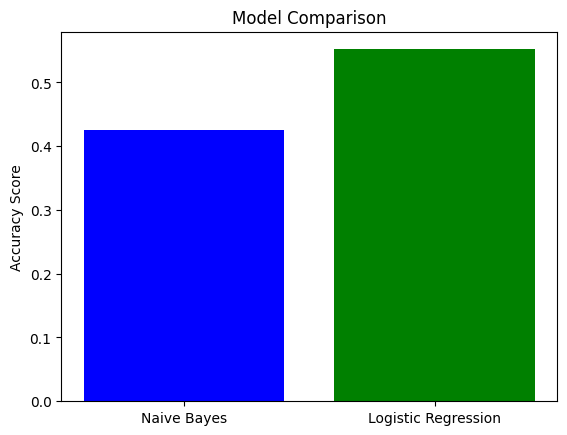

In [26]:
# İki modelin doğruluk oranını karşılaştıralım
models = ['Naive Bayes', 'Logistic Regression']
accuracy = [accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_lr)]

plt.bar(models, accuracy, color=['blue', 'green'])
plt.ylabel("Accuracy Score")
plt.title("Model Comparison")
plt.show()
